In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotnine as p9

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

In [2]:
#reading in data
train = pd.read_csv('../datasets/cleaned_train.csv', keep_default_na=False, na_values=[''])
test = pd.read_csv('../datasets/cleaned_test.csv', keep_default_na=False, na_values=[''])

In [3]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Bathrooms,SF
0,109,533352170,60,RL,69.0552,13517,Pave,NA,IR1,Lvl,...,NA,NA,NA,0,3,2010,WD,130500,3.0,2204.0
1,544,531379050,60,RL,43.0000,11492,Pave,NA,IR1,Lvl,...,NA,NA,NA,0,4,2009,WD,220000,4.0,3035.0
2,153,535304180,20,RL,68.0000,7922,Pave,NA,Reg,Lvl,...,NA,NA,NA,0,1,2010,WD,109000,2.0,2114.0
3,318,916386060,60,RL,73.0000,9802,Pave,NA,Reg,Lvl,...,NA,NA,NA,0,4,2010,WD,174000,3.0,1828.0
4,255,906425045,50,RL,82.0000,14235,Pave,NA,IR1,Lvl,...,NA,NA,NA,0,3,2010,WD,138500,2.0,2121.0


In [4]:
#genereates model preidctions of a model
def rmse(model, X, y):
    model_preds = model.predict(X)
    mse = mean_squared_error(y, model_preds)
    return mse ** 0.5

In [5]:
numeric_cols = train._get_numeric_data().columns

In [6]:
corrs = pd.DataFrame(train.corr()['SalePrice'])
corrs

,SalePrice
Id,-0.052126
PID,-0.255068
MS SubClass,-0.085730
Lot Frontage,0.338851
Lot Area,0.302747
Overall Qual,0.804655
Overall Cond,-0.097462
Year Built,0.573344
Year Remod/Add,0.551491
Mas Vnr Area,0.514035


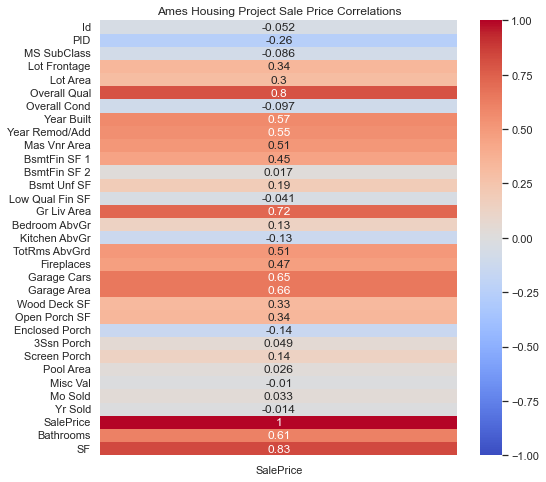

In [7]:
sns.set(rc = {'figure.figsize':(8,8)})
sns.heatmap(train.corr()[['SalePrice']], vmin = -1, annot = True, cmap = 'coolwarm')
plt.title('Ames Housing Project Sale Price Correlations');
plt.savefig('../images/correlations.jpg');

In [8]:
obj_cols = [each for each in train.columns if each not in numeric_cols]
problem_cols = ['Neighborhood', 'Condition 1', 'Condition 2', 'MS Zoning']
train_dummies = pd.get_dummies(train, columns=problem_cols)
test_dummies = pd.get_dummies(test, columns=problem_cols)
missing_from_test = [col for col in train_dummies.columns if col not in test_dummies.columns]
test_dummies[missing_from_test] = 0
train_dummies.head(3)

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM
0,109,533352170,60,69.0552,13517,Pave,NA,IR1,Lvl,AllPub,...,0,0,0,0,0,0,0,0,1,0
1,544,531379050,60,43.0000,11492,Pave,NA,IR1,Lvl,AllPub,...,0,0,0,0,0,0,0,0,1,0
2,153,535304180,20,68.0000,7922,Pave,NA,Reg,Lvl,AllPub,...,0,0,0,0,0,0,0,0,1,0


In [9]:
higher_corrs = corrs[corrs.values > .6].index

In [10]:
higher_corrs

Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'SalePrice', 'Bathrooms', 'SF'],
      dtype='object')

In [11]:
train.isna().sum().sort_values()

Id                0
Garage Finish     0
Garage Type       0
Fireplace Qu      0
Fireplaces        0
                 ..
Roof Style        0
Year Remod/Add    0
Year Built        0
Overall Qual      0
SF                0
Length: 75, dtype: int64

In [12]:
train[obj_cols]

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type
0,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,...,NA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD
1,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,...,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD
2,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,NA,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD
3,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,...,NA,BuiltIn,Fin,TA,TA,Y,NA,NA,NA,WD
4,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,...,NA,Detchd,Unf,TA,TA,N,NA,NA,NA,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,RL,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,...,Gd,Attchd,Fin,TA,TA,Y,NA,NA,NA,WD
2043,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,...,NA,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD
2044,RL,Pave,NA,Reg,Bnk,AllPub,Inside,Gtl,Crawfor,Norm,...,TA,Detchd,Unf,Fa,Fa,Y,NA,NA,NA,WD
2045,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Gd,Attchd,Unf,TA,TA,Y,NA,NA,NA,WD


In [13]:
ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(train[problem_cols])

train_ohe = pd.DataFrame(
    ohe.transform(train[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

train_ohe.head(3)

,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,...,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
train._get_numeric_data().columns

Index(['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice', 'Bathrooms',
       'SF'],
      dtype='object')

In [15]:
test_ohe = pd.DataFrame(
    ohe.transform(test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

full_train = pd.concat([train, train_ohe], axis = 1)
full_test = pd.concat([test, test_ohe], axis = 1)

# num_cols = train._get_numeric_data().drop(columns = ['Id', 'PID', 'SalePrice', 'Bathrooms']).columns
# features = list(num_cols) + problem_cols
num_cols = higher_corrs.drop(['SalePrice', 'Bathrooms'])
features = list(num_cols) + problem_cols

In [16]:
X = train[features]
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')
ohe.fit(X_train[problem_cols])

#convert  training problem columns
X_train_ohe = pd.DataFrame (
    ohe.transform(X_train[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

X_test_ohe = pd.DataFrame (
    ohe.transform(X_test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

In [17]:
X_train_full = pd.concat([X_train.reset_index(drop = True), X_train_ohe], axis = 1).drop(columns = problem_cols)
X_test_full = pd.concat([X_test.reset_index(drop=True), X_test_ohe], axis = 1).drop(columns = problem_cols)

In [18]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LassoCV(verbose = True))
])

pipe.fit(X_train_full, y_train)
pipe.score(X_train_full, y_train), pipe.score(X_test_full, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


(0.8570922313355396, 0.8344857139827335)

In [19]:
rmse(pipe, X_train_full, y_train), rmse(pipe, X_test_full, y_test)

(29879.102108890755, 32208.813797242947)

In [20]:
test_ohe = pd.DataFrame(
    ohe.transform(test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

In [21]:
test_subset = pd.concat([test[features].drop(columns = problem_cols), test_ohe], axis = 1).fillna(0)

In [22]:
preds = pipe.predict(test_subset)

In [23]:
lasso_coefs = pipe.named_steps['lr'].coef_
coef_df = pd.DataFrame(lasso_coefs, index = X_train_full.columns, columns = ['coef val'])
coef_df.sort_values(by='coef val')

,coef val
MS Zoning_RM,-4199.681272
Neighborhood_SWISU,-2583.860626
Neighborhood_NWAmes,-2252.276192
Neighborhood_NPkVill,-2193.641043
Neighborhood_NAmes,-1906.214652
Condition 1_Artery,-1897.434602
Neighborhood_Edwards,-1819.914846
Neighborhood_OldTown,-1712.627645
Condition 2_RRAe,-1107.978709
Neighborhood_IDOTRR,-1020.708710


In [24]:
sum(coef_df['coef val'] == 0)

9

In [25]:
test_ohe = pd.DataFrame(
    ohe.transform(test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)
test_subset = pd.concat([test[features].drop(columns = problem_cols), test_ohe], axis = 1).fillna(0)
preds = pipe.predict(test_subset)

In [26]:
preds = pd.DataFrame(
    pipe.predict(test_subset),
    columns = ['SalePrice']
)
preds = pd.concat([pd.DataFrame(test.Id, columns = ['Id']), preds], axis = 1)

In [27]:
preds.to_csv('../datasets/submission_lasso.csv', index_label = False, index = False, columns = preds.columns)

---------------------

In [28]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', RidgeCV())
])

pipe.fit(X_train_full, y_train)
pipe.score(X_train_full, y_train), pipe.score(X_test_full, y_test)

(0.8572810260136329, 0.8344113042027453)

In [29]:
rmse(pipe, X_train_full, y_train), rmse(pipe, X_test_full, y_test)

(29859.35902624556, 32216.052995449594)

In [30]:
test_ohe = pd.DataFrame(
    ohe.transform(test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

In [31]:
test_subset = pd.concat([test[features].drop(columns = problem_cols), test_ohe], axis = 1).fillna(0)

In [32]:
preds = pipe.predict(test_subset)

In [33]:
ridge_coefs = pipe.named_steps['lr'].coef_
coef_df = pd.DataFrame(ridge_coefs, index = X_train_full.columns, columns = ['coef val'])
coef_df.sort_values(by='coef val')

,coef val
Neighborhood_NAmes,-3141.984105
Neighborhood_SWISU,-3105.414026
Neighborhood_NWAmes,-2968.159700
Neighborhood_OldTown,-2832.179695
Neighborhood_Edwards,-2824.780243
MS Zoning_RM,-2755.550180
Neighborhood_NPkVill,-2617.562081
Neighborhood_IDOTRR,-1875.970377
Condition 1_Artery,-1690.875423
Neighborhood_SawyerW,-1478.991369


In [34]:
sum(coef_df['coef val'] == 0)

0

In [35]:
test_ohe = pd.DataFrame(
    ohe.transform(test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)
test_subset = pd.concat([test[features].drop(columns = problem_cols), test_ohe], axis = 1).fillna(0)
preds = pipe.predict(test_subset)

In [36]:
preds = pd.DataFrame(
    pipe.predict(test_subset),
    columns = ['SalePrice']
)
preds = pd.concat([pd.DataFrame(test.Id, columns = ['Id']), preds], axis = 1)

In [37]:
pd.concat([pd.DataFrame(ridge_coefs, index = X_train_full.columns, columns=['ridge']), pd.DataFrame(lasso_coefs, index = X_train_full.columns, columns=['lasso'])])

,ridge,lasso
Overall Qual,23462.020823,NaN
Gr Liv Area,10334.245424,NaN
Garage Cars,-382.876001,NaN
Garage Area,9761.317119,NaN
SF,26046.105755,NaN
...,...,...
MS Zoning_FV,NaN,1076.835330
MS Zoning_I (all),NaN,684.711768
MS Zoning_RH,NaN,-707.172185
MS Zoning_RL,NaN,0.000000


In [38]:
preds.to_csv('../datasets/submission_ridge.csv', index_label = False, index = False, columns = preds.columns)